# IDB_drilling_monitoring_shap

## Import packages

In [1]:
import gc
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as scio
import shap
import soundfile
import time
from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D
from keras.models import load_model, Model, Sequential
from keras.utils import to_categorical
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm

!nvidia-smi

HOST_path = "/root/autodl-tmp"
SETS_path = os.path.join(HOST_path, "IDB_drilling_monitoring/datasets")
SAVE_path = os.path.join(HOST_path, "IDB_drilling_monitoring/shap")

if not os.path.exists(SAVE_path):
    os.makedirs(SAVE_path)

2023-11-17 10:17:05.131493: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Fri Nov 17 10:17:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:98:00.0 Off |                  Off |
| 30%   27C    P8    18W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import datasets

In [2]:
X_set = np.load(os.path.join(SETS_path, "X_set.npy"))
X_set_cnn = np.load(os.path.join(SETS_path, "X_set_cnn.npy"))
Y_set = np.load(os.path.join(SETS_path, "Y_set.npy"))
ALL7 = np.load(os.path.join(SETS_path, "ALL7.npy"))
ALL6 = np.load(os.path.join(SETS_path, "ALL6.npy"))
HEIGHT = np.load(os.path.join(SETS_path, "HEIGHT.npy"))
RPM = np.load(os.path.join(SETS_path, "RPM.npy"))
TORQUE = np.load(os.path.join(SETS_path, "TORQUE.npy"))
PUMPR = np.load(os.path.join(SETS_path, "PUMPR.npy"))
PUMPP = np.load(os.path.join(SETS_path, "PUMPP.npy"))
ROP = np.load(os.path.join(SETS_path, "ROP.npy"))
WOB = np.load(os.path.join(SETS_path, "WOB.npy"))

print(X_set.shape)
print(X_set_cnn.shape)
print(Y_set.shape)
print(ALL7.shape)
print(ALL6.shape)
print(HEIGHT.shape)
print(RPM.shape)
print(TORQUE.shape)
print(PUMPR.shape)
print(PUMPP.shape)
print(ROP.shape)
print(WOB.shape)

(35524, 12000)
(35524, 12000, 1)
(35524, 7)
(35524, 7)
(35524, 6)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)


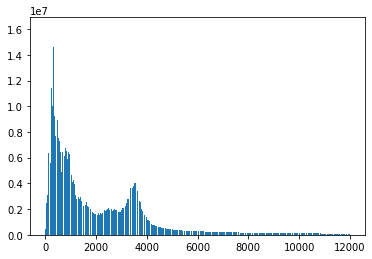

In [3]:
def distributionOf(arr):
    Freq = np.sum(arr, axis=0)
    plt.bar(np.arange(arr.shape[1]), Freq)
    plt.show()

distributionOf(X_set)

In [4]:
print(X_set.shape)
print(X_set)

(35524, 12000)
[[ 3.69545312 10.0336584   5.00140735 ...  3.62882899  1.9633871
   1.55529765]
 [ 4.46275059  9.47017867 10.35649324 ...  1.92746959  1.61736184
   3.70639905]
 [ 3.81786369 11.04322585 13.54993743 ...  2.82333739  1.30031815
   3.25870772]
 ...
 [10.7989744  12.70249237 13.64979581 ...  0.12924805  0.30560761
   0.07823928]
 [ 5.84249246  3.35302212  6.99121709 ...  0.23678803  0.12476213
   0.14811056]
 [ 0.85414921  3.55850481  2.23368328 ...  0.34487924  0.45839801
   0.18501066]]


In [5]:
# X_set = X_set[0:6000]
# print(X_set.shape)
# print(X_set)

### DATA

In [6]:
DATA = "ROP"

In [7]:
# DATA_path = os.path.join(HOST_path, "IDB_drilling_monitoring/evaluation/"+DATA)
    
# model = load_model(os.path.join(HOST_path, "IDB_drilling_monitoring/outputs_"+DATA+"/best_model.hdf5"))

In [8]:
INPUT = X_set
OUTPUT = eval(DATA)

if OUTPUT.ndim == 1:
    num_targets = 1
else:
    num_targets = OUTPUT.shape[1]

print(INPUT.shape)
print(OUTPUT.shape)
print(num_targets)

(35524, 12000)
(35524,)
1


In [9]:
# X = pd.DataFrame(data=INPUT, columns=[f"{i}Hz" for i in range(1, INPUT.shape[1]+1)])
# Y = OUTPUT

# print(type(X), X.shape)
# print(type(y), y.shape)

In [10]:
# print(X)
# print(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(INPUT, OUTPUT, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(28419, 12000)
(28419,)
(7105, 12000)
(7105,)


In [12]:
# X_train2 = X_train.reshape(28419, 12000)
# print(X_train2.shape)

In [13]:
X_train_summary = shap.kmeans(X_train, 10)

In [14]:
def print_accuracy(f):
    print("Root mean squared test error = {}".format(np.sqrt(np.mean((f(X_test) - y_test) ** 2))))
    time.sleep(0.5)  # to let the print get out before any progress bars

In [15]:
shap.initjs()

### Model

#### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

lin_regr = LinearRegression()
lin_regr.fit(X_train, Y_train)

print("Test R^2 Score  : ", lin_regr.score(X_test, Y_test))
print("Train R^2 Score : ", lin_regr.score(X_train, Y_train))

Test R^2 Score  :  0.8072292056132844
Train R^2 Score :  0.9414130568175361


In [17]:
feature_names = [f"{i}Hz" for i in range(1, INPUT.shape[1]+1)]
print(feature_names[:10])
print(feature_names[-10:])

['1Hz', '2Hz', '3Hz', '4Hz', '5Hz', '6Hz', '7Hz', '8Hz', '9Hz', '10Hz']
['11991Hz', '11992Hz', '11993Hz', '11994Hz', '11995Hz', '11996Hz', '11997Hz', '11998Hz', '11999Hz', '12000Hz']


In [18]:
ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)

##### Signle

In [19]:
shap_values = ex.shap_values(X_test[0, :])
print(shap_values)

[0. 0. 0. ... 0. 0. 0.]


In [20]:
shap.force_plot(ex.expected_value, shap_values, X_test[0, :])

##### Multi

In [21]:
shap_values = []

In [22]:
def plot_value(x):
    SHAP_value = ex.shap_values(X_test[x, :])
    print(SHAP_value.shape, SHAP_value)
    return SHAP_value

In [ ]:
for i in tqdm(range(100)):
    shap_values.append(plot_value(i))

  1%|          | 1/100 [06:48<11:13:33, 408.21s/it]

(12000,) [0. 0. 0. ... 0. 0. 0.]


In [ ]:
shap_values = np.array(shap_values)
print(shap_values.shape)

In [ ]:
np.save(os.path.join(HOST_path, "IDB_drilling_monitoring/shap_values.npy"), shap_values)

In [ ]:
shap.summary_plot(shap_values, X_test[0:10])

In [ ]:
shap.summary_plot(shap_values, X_test[0:10], plot_type="bar", sort=True)

In [ ]:
shap.force_plot(ex.expected_value, shap_values[0], X_test[0, :])

In [ ]:
shap.force_plot(ex.expected_value, shap_values, X_test[0:10])

#### CNN Model

In [ ]:
ex = shap.KernelExplainer(model.predict, X_train)

In [ ]:
X_test2 = X_test.reshape(7105, 12000)
print(X_test2.shape)
print(X_test2)

In [ ]:
shap_values = ex.shap_values(X_test2[0, :])
print(shap_values)

In [ ]:
shap.summary_plot(shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values[0], X_test, plot_type="bar", sort=True)

In [ ]:
shap.decision_plot(expected_value[0], shap_values[0], X_test, ignore_warnings=True)

In [ ]:
shaps = shap_values[0]
shaps_mean = np.abs(shaps).mean(axis=0)
feature_names = df.drop('type',axis=1).columns

sorted_indices = np.argsort(shaps_mean)[::-1]
sorted_features = feature_names[sorted_indices] 
sorted_shaps_mean = shaps_mean[sorted_indices]
max_display = 20  
selected_features = sorted_features[:max_display]
selected_shaps_mean = sorted_shaps_mean[:max_display]
fig, ax = plt.subplots()
ax.barh(np.arange(max_display), selected_shaps_mean, align='center', color='b')
ax.set_yticks(np.arange(max_display))
ax.set_yticklabels(selected_features)
ax.invert_yaxis()
ax.set_xlabel('Mean(|SHAP value|)(average impact on model output magnitude)')
# ax.set_xlabel('Mean Absolute SHAP Value')
# ax.set_title('Summary Plot of SHAP Values')
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_20.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_all.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_all.png"), dpi=300)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rforest = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rforest.fit(X_train, Y_train)

print("Test R^2 Score  : ", lin_regr.score(X_test, Y_test))
print("Train R^2 Score : ", lin_regr.score(X_train, Y_train))

In [ ]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rforest)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)